# 코로나 네이버 뉴스 API 감성분석
    머신러닝2_6일차 참조

# 네이버 뉴스 크롤링

In [3]:
import pandas as pd
import numpy as np

In [4]:
# 함수 설계
import os
import sys
import urllib.request
import json
client_id = "J2KwXxSxDGbKmuP9V6eE"
client_secret = "NOtfPphkJY"
def getRequestUrl(url):
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)
    try:
        response = urllib.request.urlopen(request)
        rescode = response.getcode()
        if(rescode==200): # 성공
            response_body = response.read()
            return response_body.decode('utf-8')
        else:
            print("Error Code:" + rescode)  # 404(경로가 잘못), 500(내부에러)
            return None
    except Exception as e:
        print(e)
        return None
        
def getNeverSearch(srcText,searchType='news',display=10,start=1):
    encText = urllib.parse.quote(srcText)
    url = f"https://openapi.naver.com/v1/search/{searchType}.json?query={encText}&display={display}&start={start}&sort=sim"
    jsonData =  getRequestUrl(url)
    if jsonData == None:
        return None
    else:
        return json.loads(jsonData)

In [5]:
searchRange = [i for i in range(1,1000,100)] + [1000]  
result = []
for start in searchRange:
    result += getNeverSearch('코로나',start=start, display=100)['items']

In [17]:
### 분석에 필요한 데이터 추출    
data_title = []
data_description = []
for item in result:
    data_title.append(item['title'])
    data_description.append(item['description'])

In [157]:
data_df = pd.DataFrame({'title':data_title, 'description' : data_description})

In [158]:
data_df.to_csv('코로나 뉴스.csv',encoding='utf-8')

In [159]:
pd.read_csv('코로나 뉴스.csv',index_col=0)

,title,description
0,"“<b>코로나</b> 백신, 고위험군 年2회 접종을”",지영미 질병관리청장이 앞으로 “신종 <b>코로나</b>바이러스 감염증(<b>코로나<...
1,"방역당국 &quot;<b>코로나</b>백신 정례접종, 변이예측·백신개발 보며 검토&...","방역 당국이 <b>코로나</b>19 백신의 정례접종 도입을 검토할 때 변이 예측, ..."
2,방역당국 &quot;<b>코로나</b> 백신 연 1~2회 정기접종 검토 중&quot;,방역당국이 <b>코로나</b>19 변이 예측과 백신 개발 상황 등을 고려해 백신 정...
3,폐업신고 않고 매출실적 낮춰 <b>코로나</b> 지원금 ‘꿀꺽’,특히 <b>코로나</b>19 소상공인 지원금 부정수급 신고 관련 상담이 1년 전보다...
4,"&apos;<b>코로나</b> 수혜&apos; 줌, 직원 1300명 감원 발표",<b>코로나</b>19 팬데믹 대표 수혜 기업 중 하나인 화상회의 업체 줌 비디오 ...
...,...,...
1095,"美, 5월 11일 &apos;<b>코로나</b>19 비상&apos; 종료 예정",미국 정부가 오는 5월 11일 <b>코로나</b>19로 인한 공중보건 비상사태를 종...
1096,"캐나다, 중국발 입국자 <b>코로나</b>19 의무 검사 두달 연장","캐나다가 중국, 홍콩, 마카오에서 입국한 여행객에 대한 <b>코로나</b>19 의무..."
1097,"중국, 한국발 입국자에 <b>코로나</b> 검사…중국인은 제외",<b>코로나</b>19 검사를 예고대로 시행하면서 자국민은 제외한 외국 국적자에 대...
1098,[<b>코로나</b>19]부산 신규 확진 337명,부산시 방역당국은 오늘 0시 기준 부산지역 <b>코로나</b>19 신규 확진자는 3...


In [24]:
data_df.head()

,title,description
0,"“<b>코로나</b> 백신, 고위험군 年2회 접종을”",지영미 질병관리청장이 앞으로 “신종 <b>코로나</b>바이러스 감염증(<b>코로나<...
1,"방역당국 &quot;<b>코로나</b>백신 정례접종, 변이예측·백신개발 보며 검토&...","방역 당국이 <b>코로나</b>19 백신의 정례접종 도입을 검토할 때 변이 예측, ..."
2,방역당국 &quot;<b>코로나</b> 백신 연 1~2회 정기접종 검토 중&quot;,방역당국이 <b>코로나</b>19 변이 예측과 백신 개발 상황 등을 고려해 백신 정...
3,폐업신고 않고 매출실적 낮춰 <b>코로나</b> 지원금 ‘꿀꺽’,특히 <b>코로나</b>19 소상공인 지원금 부정수급 신고 관련 상담이 1년 전보다...
4,"&apos;<b>코로나</b> 수혜&apos; 줌, 직원 1300명 감원 발표",<b>코로나</b>19 팬데믹 대표 수혜 기업 중 하나인 화상회의 업체 줌 비디오 ...


# title에 대한 감성 분석
    1.감성분석(td-idf)을 실시할 데이터의 피처 벡터화
    2.감성분석 - 로지스틱회귀 - 파라메터는 하이터 튜닝
    3.결과를 프레임에 저장

In [28]:
from konlpy.tag import Okt
okt = Okt()
# 토큰화 작업을 수행할 함수를 작성
def okt_tokenizer(text):
    tokens =  okt.morphs(text)
    return tokens
# tf-idf로 벡터화
from sklearn.feature_extraction.text import TfidfVectorizer
# 모델
tfidf =  TfidfVectorizer(tokenizer=okt_tokenizer,
                ngram_range=(1,2),         #  토큰의 단어크기를 1~2개 단어로
                min_df=3,                  # 출현 빈도가 최소 3번 이상
                max_df= 0.9                # 최대 90% 이하인 것만 사용
               )
tfidf.fit(data_df['title'])

C:\Users\user\miniconda3\envs\py\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2),
                tokenizer=<function okt_tokenizer at 0x000001E57ACFB760>)

In [30]:
# 1
data_title_tfidf = tfidf.transform(data_df['title'])
data_title_tfidf.shape

(1100, 1626)

In [37]:
# 이전에서 학습했던 학습용 데이터를 가지고 머신러닝 모델을 만든다
train_df = pd.read_csv('ratings_train.txt',encoding='utf-8',sep='\t')
train_df.dropna(subset=['document'],axis = 0,inplace=True)
train_df.reset_index(drop=True,inplace=True)
import re
train_df['document'] = train_df['document'].apply(lambda x : re.sub(r'[^ㄱ-ㅎ가-힣]+'," ",x))
train_tfidf = tfidf.transform(train_df['document'])

In [38]:
#2 머신러닝을 학습 - 하이퍼 파라메터 튜닝
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression(random_state=0)
param ={
    'C':range(1,10)
}
gsc = GridSearchCV(lr,param_grid=param, cv=3,scoring='accuracy',verbose = 1)
# 문장과 (학습)  긍정 부정(타겟)
gsc.fit(train_tfidf,train_df['label'])

Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\user\miniconda3\envs\py\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\miniconda3\envs\py\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=0),
             param_grid={'C': range(1, 10)}, scoring='accuracy', verbose=1)

In [39]:
# 파이퍼 파라메터 C 는 6
gsc.best_params_

{'C': 6}

In [40]:
# Best 한 모델객체 저장
import pickle
pickle.dump(gsc.best_estimator_, open('logistic_tfidf.sav', 'wb'))

In [41]:
# 머신러닝 모델 불러오기(pickle)
loaded_lr = pickle.load(open('logistic_tfidf.sav','rb'))

In [42]:
data_df['title_label'] =  loaded_lr.predict(data_title_tfidf)

In [43]:
# description에 대해서 감성 분석
data_df_tfidf = tfidf.transform(data_df['description'])
data_df['description_label'] =  loaded_lr.predict(data_df_tfidf)

In [45]:
data_df['title_label'].value_counts(), data_df['description_label'].value_counts()

(0    791
 1    309
 Name: title_label, dtype: int64,
 0    871
 1    229
 Name: description_label, dtype: int64)

In [47]:
# 분석결과 저장
data_df.to_csv('코로나네이버뉴스api감성분석.csv',encoding='utf-8')

# 결과
    - title분석결과와 description 분석 결과에 차이가 있음
    - 단어를 기준으로 분석하기 때문에 단어의 개수가 부족하면 정확도가 떨어진다.
    - 영화리뷰를 학습한 머신러닝을 가지고 뉴스를 분석... 단어의 차이에대한 오차가 있을 것

### 감성분석 결과를 분리 저장 - 뉴스본문에 대한 감성분석을 기준으로  긍정 부정을 분리하고 비교 분석

In [78]:
import copy
# negative_df =  copy.deepcopy(data_df)
# pogitive_df =  copy.deepcopy(data_df)
# col_names = ['title', 'title_label','description', 'description_label'] 
# negative_df = pd.DataFrame(columns=col_names)
# pogitive_df = pd.DataFrame(columns=col_names)
negative_df =  copy.deepcopy(data_df[data_df['description_label'] == 0])
pogitive_df =  copy.deepcopy(data_df[data_df['description_label'] == 1])

In [79]:
negative_df.shape, pogitive_df.shape

((871, 4), (229, 4))

# 결과 시각화
    긍정에대한 감성뉴스에서 형태소 분석

In [83]:
from konlpy.tag import Okt
okt = Okt()
pogitive_description_noun_tk = []
for word in pogitive_df['description']:
    pogitive_description_noun_tk.append(okt.nouns(word))      # 형태소 토근화 하여 명사 토큰만 추출해서 리스트를 구성

In [88]:
len(pogitive_description_noun_tk)

229

In [93]:
# 토큰의 길이가 1인 단어는 제외
pogitive_result = []
for listdata in pogitive_description_noun_tk:
    # 단어의 길이가 1보다큰 즉 2이상인 단어만 추출
    temp = [w for w in listdata if len(w) > 1]    
    pogitive_result.append(" ".join(temp))    

In [102]:
# 아무것도없는 데이터 제거 - 전처리
pogitive_result = [w for w in pogitive_result if w != '']
pogitive_result[:5]

['순이익 신세계 인터 센트럴시티 자회사 성장 서울 뉴시스 이혜원 기자 신세계 코로나 기점 폭발 성장 코로나 한창 명품 특수 성장',
 '기사 내용 요약 승승장구 김치 작년 수출 감소 코로나 특수 한류 한식 인기 지속 전망 서울 뉴시스 김혜경 기자 김치 수출 지난해 감소 세로 코로나 특수',
 '코로나 대유행 개월 주가 코로나 테마주 실상 직접 체외 진단 의료기기 진단 키트 검체 수송 배지 자체 생산 기술 인력 설비',
 '방역 당국 신종 코로나 바이러스 감염증 코로나 백신 정례 화해 접종 방안 검토 발표 계획 코로나 엔데믹 풍토병 이후 독감 매년 접종',
 '경북 코로나 진자 북도 전날 포항 구미 코로나 전담 병원 병상 입원 가동 보이']

In [101]:
from functools import reduce
a = [[1],[2],[3]]
reduce(lambda x,y : x+y, a)

[1, 2, 3]

In [ ]:
# 머신러닝... 사이킷런 밑에 model_selection 에 주로 있고.
# 모델객체생성 -> 학습 -> 예측 -> 평가
# lr = linearGegration()  
# lr.fit(학습데이터, 정답)
# 예측값 = lr.predict(테스트데이터)
# lr.score(테스트데이터, 정답)   정확도..    정밀하게 볼려면 F1-score

# 유틸리티, StandardSacle(), tf-idf
# fit(적용할 데이터)  유틸리티에 적용할 데이터를 셋팅
# transform(적용할 데이터) 결과를 리턴

# fit_transform(적용할 데이터)

    부정에대한 감성뉴스에서 형태소 분석

In [113]:
negative_description_noun_tk = []
for word in negative_df['description']:
    negative_description_noun_tk.append(okt.nouns(word))  
# 토큰의 길이가 1인 단어는 제외
negative_result = []
for listdata in negative_description_noun_tk:
    # 단어의 길이가 1보다큰 즉 2이상인 단어만 추출
    temp = [w for w in listdata if len(w) > 1]    
    negative_result.append(" ".join(temp))   
negative_result = [w for w in negative_result if w != '']
negative_result[:5]    

['지영미 질병 관리 청장 신종 코로나 바이러스 감염증 코로나 백신 정례 접종 합리 코로나 팬데믹 대유행 엔데믹 풍토병 전환',
 '방역 당국 코로나 백신 정례 접종 도입 검토 예측 백신 개발 상황 고려 임숙영 중앙 방역 대책 본부 대본 상황 총괄 단장 브리핑 정례 접종 추진',
 '방역 당국 코로나 예측 백신 개발 상황 고려 백신 정례 접종 검토 앞서 지영미 질병 관리 청장 전날 취임 기자간담회 코로나 백신 정례 접종 언급',
 '코로나 소상 공인 원금 부정 수급 신고 관련 상담 전보 급증 국민권익위 코로나 소상 공인 원금 부정 수급 신고 관련 상담 권익위 관계자',
 '코로나 팬데믹 대표 수혜 기업 하나 화상회의 업체 비디오 커뮤니케이션 현지 시간 에릭 위안 최고경영자 블로그 통해 코로나 대유행 이후 세계 계속 회사']

    TF-IDF기반의 DTM 구성하기 긍정감성뉴스에 대한 DTM을 구성

In [115]:
pos_tfidf =  TfidfVectorizer(tokenizer=okt_tokenizer, min_df=2)
pos_dtm =  pos_tfidf.fit_transform(pogitive_result)

C:\Users\user\miniconda3\envs\py\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [119]:
pos_dtm.getcol(0).sum()

0.749623567058193

In [117]:
# DTM의 단어(get_feature_names_out()) 마다 컬럼의 합을 구해서 단어별 tfidf값의 하비을 구하고 내림차순으로 정렬
pos_vocab = {}
for idx, word in  enumerate(pos_tfidf.get_feature_names_out()):
    pos_vocab[word] = pos_dtm.getcol(idx).sum()

In [120]:
pos_vocab

{'가까이': 0.749623567058193,
 '가동': 1.723099477563374,
 '가스': 0.6740515928669168,
 '가운데': 2.2764431194098713,
 '가장': 2.320359830209491,
 '가정': 0.5360321186421847,
 '가족': 1.031179522870008,
 '가지': 0.7000110312983654,
 '각각': 1.0675909722459291,
 '감소': 2.925731611006275,
 '감염': 4.956358583786514,
 '감염병': 1.924475701540556,
 '감염증': 4.701068786890271,
 '강행': 0.6371741897832206,
 '개방': 0.7638930191642785,
 '개선': 1.359281500929793,
 '개월': 3.815254821198513,
 '개인': 1.0854879546803098,
 '개최': 0.734444365147602,
 '거리': 1.3669701852174998,
 '건강': 1.3212062870851957,
 '건국절': 0.4058794165897179,
 '건수': 0.634601252370751,
 '검사': 6.03456507998213,
 '검토': 0.5085334376855004,
 '게시': 0.49411624044890784,
 '겨울': 0.5233931235023583,
 '격리': 1.0213966644338919,
 '결과': 1.885721550006172,
 '결정': 0.6855373044107627,
 '경계': 1.450260191949897,
 '경기': 0.5768726852714923,
 '경북': 1.9092349530977761,
 '경우': 0.8680111805904422,
 '경제': 0.8371552809440985,
 '경찰': 0.5830722556737802,
 '계속': 0.6740515928669168,
 '계층': 0.65

In [121]:
pos_word = sorted(pos_vocab.items(),key=lambda x : x[1], reverse=True)

In [126]:
pos_word[:5]

[('코로나', 24.096373890903067),
 ('진자', 11.184461261077999),
 ('재난', 8.142841952944856),
 ('문자', 8.044143555087247),
 ('이후', 7.073238988007887)]

    부정감성에대해서도 동일하게 적용

In [124]:
neg_tfidf =  TfidfVectorizer(tokenizer=okt_tokenizer, min_df=2)
neg_dtm =  neg_tfidf.fit_transform(negative_result)
neg_vocab = {}
for idx, word in  enumerate(neg_tfidf.get_feature_names_out()):
    neg_vocab[word] = neg_dtm.getcol(idx).sum()
neg_word = sorted(neg_vocab.items(),key=lambda x : x[1], reverse=True)    

C:\Users\user\miniconda3\envs\py\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [127]:
neg_word[:5]

[('코로나', 84.88091705726454),
 ('진자', 53.35910011949402),
 ('신규', 35.03048187217518),
 ('중국', 30.869541306114094),
 ('방역', 30.60884044965689)]

In [128]:
font_path =  'C:/Windows/Fonts/HMFMOLD.TTF'
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [130]:
fm.get_fontconfig_fonts()
font_name = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font',family = font_name)

C:\Users\user\AppData\Local\Temp\ipykernel_15704\3539681690.py:1: MatplotlibDeprecationWarning: The get_fontconfig_fonts function was deprecated in Matplotlib 3.5 and will be removed two minor releases later.
  fm.get_fontconfig_fonts()


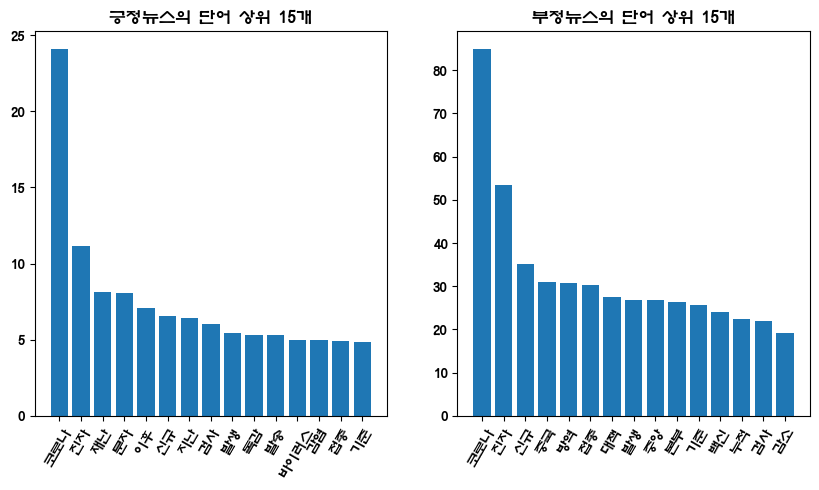

In [147]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(range(15), [i[1] for i in pos_word[:15]])
plt.title("긍정뉴스의 단어 상위 15개")
plt.xticks(range(15), [i[0] for i in pos_word[:15]], rotation = 60)

plt.subplot(1,2,2)
plt.bar(range(15), [i[1] for i in neg_word[:15]])
plt.title("부정뉴스의 단어 상위 15개")
plt.xticks(range(15), [i[0] for i in neg_word[:15]], rotation = 60)
plt.show()

# 토픽분석